In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 7.3 MB/s eta 0:00:00


In [4]:
%pip install stable-baselines3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.7/181.7 kB 3.7 MB/s eta 0:00:00


In [5]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Any
from stable_baselines3 import A2C, DQN, PPO
from stable_baselines3.common.callbacks import BaseCallback
from tqdm import tqdm
from typing import List
import time
import torch
import random

env_name = "custom-v1"

In [6]:
class ProgressBarCallback(BaseCallback):

    def __init__(self, check_freq: int, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
        return True

    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
class Order:
    price: float
    minutes_left: float

    def __init__(self, price, minutes_left):
        self.price = price
        self.minutes_left = minutes_left

    def __repr__(self):
        return f"price: {self.price}, minutes_left: {self.minutes_left}"

    @staticmethod
    def from_series(series: pd.Series):
        return Order(series[0], series[1])


class Trade(Order):
    action: int

    def __init__(self, action, price, minutes_left):
        super().__init__(price, minutes_left)
        self.action = action

    def __repr__(self):
        return f"action: {self.action}, price: {self.price}, minutes_left: {self.minutes_left}"

    @staticmethod
    def from_order(action: int, order: Order):
        return Trade(action, order.price, order.minutes_left)

    @staticmethod
    def from_series(series: pd.Series):
        raise Exception("Not implemented.")

In [8]:
BUY = 0
SELL = 1
HOLD = 2

BASE_FLEX_PRICE = 100


class CustomEnv(gym.Env):
    def __init__(self, df):
        self.action_space = gym.spaces.Discrete(3)
        # self.reward_range = (-1,1)
        self.observation_space = gym.spaces.Box(-np.inf, np.inf, (5,), dtype=np.float64)
        self.last_action = None
        self.total_reward = 0
        self.current_tick = 0

        self.end_tick = len(df)
        self.total_profit = 0

        self.action_history: List[Trade] = []
        self.orders: List[Order] = self._process_data(df)
        self.trade_history: List[Trade] = []

    def _avg_price(self):
        if self.current_tick > 5:
            last_orders = self.orders[self.current_tick - 5:self.current_tick]
            prices = [i.price for i in last_orders]

            sum_price = 0

            for price in prices:
                sum_price += price

            avg_price = sum_price / 5

            if avg_price > self.orders[self.current_tick].price:
                return 1
            if avg_price < self.orders[self.current_tick].price:
                return -1
            if avg_price == self.orders[self.current_tick].price:
                return 0
        else:
            last_orders = self.orders[0:self.current_tick]
            prices = [i.price for i in last_orders]

            sum_price = 0

            for price in prices:
                sum_price += price

            avg_price = sum_price / self.current_tick

            if avg_price > self.orders[self.current_tick].price:
                return 1
            if avg_price < self.orders[self.current_tick].price:
                return -1
            if avg_price == self.orders[self.current_tick].price:
                return 0
        return 0

    def _process_data(self, df):
        orders: List[Order] = []
        for i in range(len(df)):
            orders.append(Order.from_series(df.iloc[i]))
        return orders

    def _get_obs(self, action):
        if len(self.trade_history) >= 2:
            if (action == SELL or action == BUY):
                return np.array(
                    [
                        self.orders[self.current_tick].price,
                        self.trade_history[-1].action,
                        self.orders[self.current_tick].price - self.trade_history[-2].price,
                        self._avg_price(),
                        self.orders[self.current_tick].minutes_left
                    ]
                )
            return np.array(
                [
                    self.orders[self.current_tick].price,
                    self.trade_history[-1].action,
                    self.orders[self.current_tick].price - self.trade_history[-1].price,
                    self._avg_price(),
                    self.orders[self.current_tick].minutes_left
                ]
            )
        else:
            # fehlerhaft oder
            return np.array(
                [
                    self.orders[self.current_tick].price,
                    SELL,
                    BASE_FLEX_PRICE - self.orders[0].price,
                    self._avg_price(),
                    self.orders[self.current_tick].minutes_left
                ]
            )

    def _calculate_reward(self, action):
        if not len(self.trade_history) >= 2:
            return 0

        if action == SELL or action == BUY:

            this_trade = self.trade_history[-1]
            last_trade = self.trade_history[-2]

            if this_trade.action == last_trade.action:
                return -5

            if this_trade.action == SELL:
                if this_trade.price > last_trade.price:
                    return 4
                else:
                    return -1

            if this_trade.action == BUY:
                if this_trade.price < last_trade.price:
                    return 4
                else:
                    return -1

        return 0


    def dyn_calculate_reward(self, action):
        if not len(self.trade_history) >= 2:
            return 0

        if action == SELL or action == BUY:

            this_trade = self.trade_history[-1]
            last_trade = self.trade_history[-2]

            if this_trade.action == last_trade.action:
                return -15

            if this_trade.action == SELL:
                return this_trade.price - last_trade.price

            if this_trade.action == BUY:
                return last_trade.price - this_trade.price

        return 0

    def step(self, action):
        step_reward = 0
        terminated = False
        truncated = False

        self.action_history.append(Trade.from_order(action, self.orders[self.current_tick]))

        if action == SELL or action == BUY:
            self.trade_history.append(Trade.from_order(action, self.orders[self.current_tick]))

            # ##
            # if len(self.trade_history) >= 2:
            #     this_trade = self.trade_history[-1]
            #     last_trade = self.trade_history[-2]
            #
            #     if this_trade.action == last_trade.action:
            #         terminated = True
            #         self.current_tick += 1
            #         return self._get_obs(action), -50, terminated, truncated, {}
            # ##

        step_reward = self._calculate_reward(action)

        self.total_reward += step_reward
        self.total_profit = self._calculate_total_profit()

        self.last_action = action
        self.current_tick += 1

        if (self.current_tick +1) == self.end_tick:
            truncated = True
            # return np.array((0, 0, 0, 0, 0)), step_reward, terminated, truncated, {}

        return self._get_obs(action), step_reward, terminated, truncated, {}

    def render_all(self, show_hold=True, show_time_left=True):

        if show_time_left:
            window_ticks = np.arange(len(self.trade_history))
            prices = np.array([o.price for o in self.orders])
            minutes_left = np.array([i.minutes_left for i in self.orders])

            plt.xlim(max(minutes_left), min(minutes_left))
            plt.plot(minutes_left, prices)

            for i in self.action_history:
                if i.action == SELL:
                    plt.plot(i.minutes_left, i.price, 'r', marker="^", alpha=0.7)
                if i.action == BUY:
                    plt.plot(i.minutes_left, i.price, 'g', marker="v", alpha=0.7)
                if i.action == HOLD:
                    if show_hold:
                        plt.plot(i.minutes_left, i.price, 'y',  marker="o", alpha=0.7)

            plt.suptitle(
                "Total Reward: %.6f" % self.total_reward + ' ~ ' +
                "Total Profit: %.6f" % self.total_profit
            )
        else:
            window_ticks = np.arange(len(self.action_history))
            prices = np.array([o.price for o in self.orders])
            minutes_left = np.array([i.minutes_left for i in self.orders])

            plt.plot(window_ticks, prices[:-1])

            for i, action in enumerate(self.action_history):
                if action.action == SELL:
                    plt.plot(i, action.price, 'r', marker="^", alpha=0.7)
                if action.action == BUY:
                    plt.plot(i, action.price, 'g', marker="v", alpha=0.7)
                if action.action == HOLD:
                    if show_hold:
                        plt.plot(i, action.price, 'y', marker="o", alpha=0.7)

            plt.suptitle(
                "Total Reward: %.6f" % self.total_reward + ' ~ ' +
                "Total Profit: %.6f" % self.total_profit
            )

    def reset(self, seed: int | None = None, options: dict[str, Any] | None = None):
        super().reset(seed=seed, options=options)
        self.current_tick = 0
        self.total_reward = 0
        self.action_history = []
        self.trade_history = []
        self.total_profit = 0

        return np.array([
            self.orders[0].price,
            BUY,
            self.orders[0].price - BASE_FLEX_PRICE,
            0,
            self.orders[0].minutes_left
        ]), {}

    def render(self):
        ...

    def close(self):
        ...

    def _calculate_total_profit(self):
        sells = [i.price for i in self.trade_history if i.action == SELL]
        buys = [i.price for i in self.trade_history if i.action == BUY]
        return np.array(sells).sum() - np.array(buys).sum()


gym.register(id=env_name, entry_point=CustomEnv)


In [9]:
data = pd.read_parquet("/content/drive/MyDrive/RL/data.parquet")

In [10]:
df = pd.read_parquet("/content/drive/MyDrive/RL/p48.parquet")
grouped = df.groupby(['Day'])
dfs = {}
for product, group_df in enumerate(grouped):
    dfs[product] = group_df[1].reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-10-94b8ded2a7ee>:4: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for product, group_df in enumerate(grouped):


In [11]:
model = PPO.load("/content/drive/MyDrive/RL/gc_ppo_50k.zip")

In [ ]:
seed = 42

env = gym.make(env_name, df=data)
env.reset(seed=seed)

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

model = PPO("MlpPolicy", verbose=0, env=env, device="cuda")
model.learn(total_timesteps=100_000, callback=ProgressBarCallback(100))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
model.learn(): 100300it [34:52, 47.93it/s]


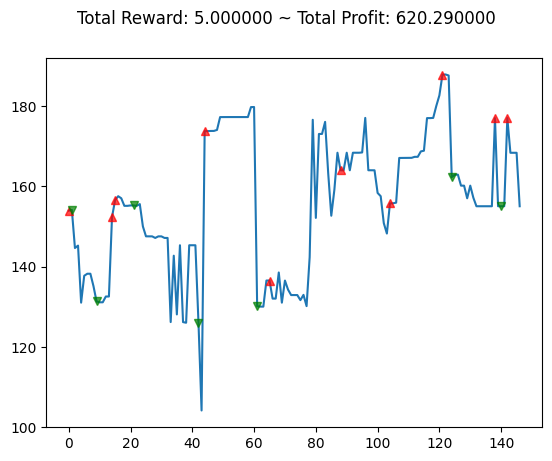

In [19]:
observations = []
rewards = []
actions = []

env_test = gym.make(env_name, df=dfs[155])
obs, _ = env_test.reset(seed=42)

observations.append(obs)


while True:
    action = model.predict(obs, deterministic=False)
    obs, reward, trun, term, _ = env_test.step(int(action[0]))
    observations.append(obs)
    rewards.append(reward)
    actions.append(int(action[0]))
    if trun or term:
        break

env_test.render_all(show_hold=False, show_time_left=False)

rewards.append(None)
actions.append(None)

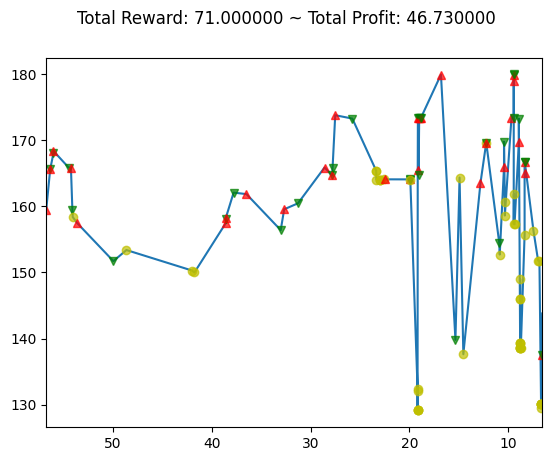

In [ ]:
env_test.render_all(show_hold=True, show_time_left=True)

In [ ]:
np_obs = np.array(observations)
np_act = np.array(actions)
np_rew = np.array(rewards)
np.column_stack((np_obs,np_act, np_rew))


array([[159.5, 0.0, 59.5, 0.0, 56.75, 1, 0],
       [165.6, 1.0, -59.5, -1.0, 56.35, 0, -1],
       [165.6, 0.0, 6.099999999999994, -1.0, 56.35, 1, -1],
       [168.1, 1.0, 2.5, -1.0, 56.016666666666666, 0, -1],
       [168.4, 0.0, 2.8000000000000114, -1.0, 56.016666666666666, 1, 4],
       [165.9, 1.0, -2.1999999999999886, -1.0, 54.483333333333334, 0, 4],
       [165.9, 0.0, -2.5, 1.0, 54.25, 1, -1],
       [159.4, 1.0, -6.5, 1.0, 54.1, 0, 4],
       [158.4, 0.0, -7.5, 1.0, 54.06666666666667, 2, 0],
       [157.51, 0.0, -1.8900000000000148, 1.0, 53.63333333333333, 1, -1],
       [151.72, 1.0, -7.680000000000007, 1.0, 49.95, 0, 4],
       [153.4, 0.0, -4.109999999999985, 1.0, 48.63333333333333, 2, 0],
       [150.3, 0.0, -1.4199999999999875, 1.0, 42.0, 2, 0],
       [150.0, 0.0, -1.7199999999999989, 1.0, 41.75, 2, 0],
       [157.5, 0.0, 5.780000000000001, -1.0, 38.56666666666667, 1, 4],
       [158.1, 1.0, 6.3799999999999955, -1.0, 38.56666666666667, 0, -1],
       [158.3, 0.0, 0.8000

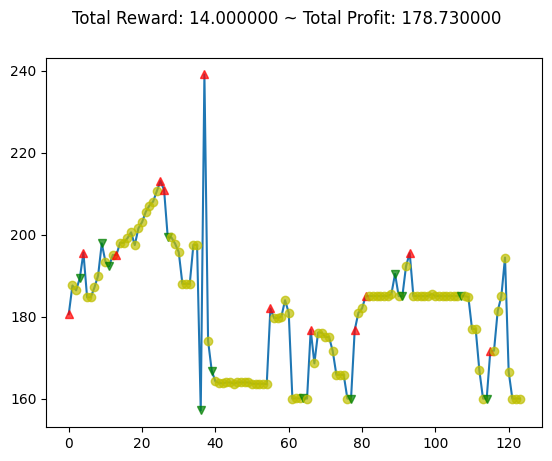

In [ ]:
observations = []
rewards = [0]
actions = [None]

env_test = gym.make(env_name, df=dfs[149])
obs, _ = env_test.reset(seed=42)

observations.append(obs)

while True:
    action = model.predict(obs)
    obs, reward, trun, term, _ = env_test.step(int(action[0]))
    rewards.append(reward)
    actions.append(int(action[0]))
    observations.append(obs)
    if trun or term:
        break

env_test.render_all(show_hold=True, show_time_left=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_all to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_all` for environment variables or `env.get_wrapper_attr('render_all')` that will search the reminding wrappers.
  logger.warn(


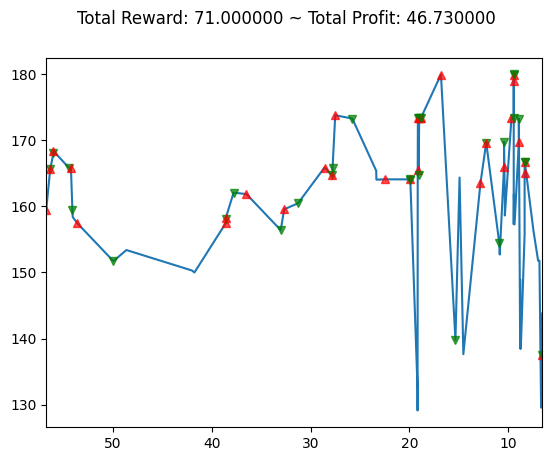

In [ ]:
env_test.render_all(show_hold=False, show_time_left=True)

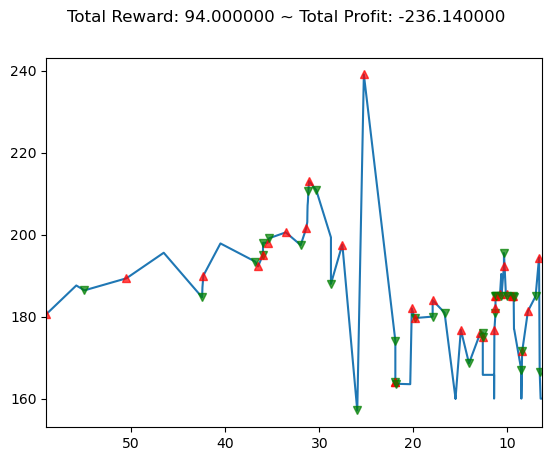

In [ ]:
env_test.render_all(show_hold=False, show_time_left=True)

In [ ]:
np_obs = np.array(observations)
np_act = np.array(actions)
np_rew = np.array(rewards)
np.column_stack((np_obs,np_act, np_rew))

In [ ]:
model.save("/content/drive/MyDrive/RL/gc_ppo_100k")

In [ ]:
# observations = []
# rewards = [None]
# actions = [None]
#
# env_test = gym.make(env_name, df=dfs[159])
# obs, _ = env_test.reset(seed=42)
#
# observations.append(obs)
#
#
# while True:
#     action = model.predict(obs)
#     obs, reward, trun, term, _ = env_test.step(int(action[0]))
#     observations.append(obs)
#     rewards.append(reward)
#     actions.append(int(action[0]))
#     if trun or term:
#         break
#
# env_test.render_all(show_hold=False, show_time_left=True)


In [ ]:
# np_obs = np.array(observations)
# np_act = np.array(actions)
# np_rew = np.array(rewards)
# np.column_stack((np_obs,np_act, np_rew))
# # BUY = 0
# # SELL = 1
# # HOLD = 2